### 베이징 미세먼지 예측하기(회귀)

- 시계열 데이터 획득 및 전처리 pandas
- RNN 모델링 tensorflow

## 작업순서
1. 데이터 획득
1. 데이터 분석(살펴보기)
1. 데이터 정제 - 누락데이터 처리 , 카테고리 -> 수치데이터로 변환 
1. 전처리 - RNN 모델로 학습할 수 있도록 X , Y 를 만들기(교사학습)
1. 정규화 (0과1사이 - minmax)
1. 학습용/테스트용 분리 
1. RNN 모델 구형
1. 학습데이터로 모델 학습시키기 - 학습용 데이터셋
1. 성능측정 - 테스트 데이터 사용 - 결정계수 사용 
1. 시각화 - 정답과 예측 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 데이터 획득

In [6]:
df = pd.read_csv("data.csv")
df.shape 

(43824, 13)

In [7]:
df.head(5)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


### dataframe 은 컬럼, 인덱스, 밸류로 구성되어 있다.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


### 머신러닝을 위해서는 모두 수치형으로 돌려줘야 하므로  cbwd    43824 non-null  object  바꿔줘야한다.

In [9]:
target = 'pm2.5' # 미세먼지 농도를 예측하기 위한 것이므로 많이 사용할 것으로 변수 선언

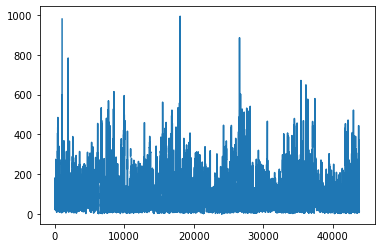

In [10]:
df[target].plot()

### 40000시간 동안 미세먼지의 변화 
### 100 이상 200 사이 정도가 많다.

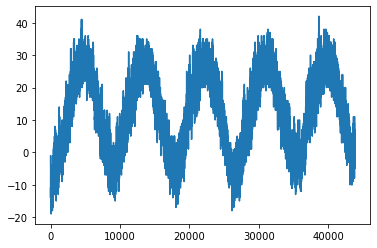

In [11]:
df['TEMP'].plot() # 온도 

### 주기로 봤을 때. 5년의 데이터를 보인다. 

In [14]:
df['year']

0        2010
1        2010
2        2010
3        2010
4        2010
         ... 
43819    2014
43820    2014
43821    2014
43822    2014
43823    2014
Name: year, Length: 43824, dtype: int64

In [16]:
df['year'].unique() # 중복되는 값 한번만 출력. - 5년 

array([2010, 2011, 2012, 2013, 2014], dtype=int64)

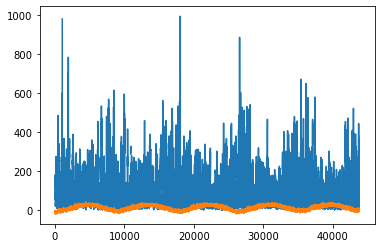

In [18]:
df[target].plot()
df['TEMP'].plot()
# 한컬럼에 두개를 넣으면 그래프를 겹쳐서 하나로 만들어 준다. 
# 온도는 40까지인데 미세먼지는 1000까지 올라가기 때문에 비교가 되지 않으므로 온도에 *10을 해보겠다. 

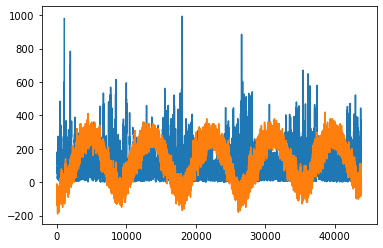

In [21]:
df[target].plot()
(df['TEMP']*10).plot()

### 온도와 미세먼지양의 시각화를 함께 봤을 때, 겨울? 봄? 에 높게 보인다. 

In [22]:
df.cbwd # 바람의 방형 

0        NW
1        NW
2        NW
3        NW
4        NW
         ..
43819    NW
43820    NW
43821    NW
43822    NW
43823    NW
Name: cbwd, Length: 43824, dtype: object

In [23]:
df.cbwd.value_counts() # 값의 회수를 세준다. 

SE    15290
NW    14150
cv     9387
NE     4997
Name: cbwd, dtype: int64

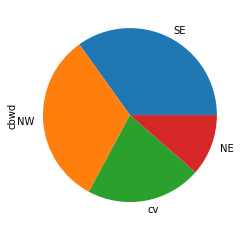

In [26]:
df.cbwd.value_counts().plot.pie() # 바람의 방향 

### 북서풍이 가장 많고, 다음으로 남동품이 높은데
### 우리나라로 오는 방향이 북서풍이기 때문에 우리나라가 많은 피해를 입는 것이다. 

## 데이터 정제 - 누락데이터 처리 , 카테고리 -> 수치데이터로 변환 

In [31]:
df.isna() # 누락 데이터 확인 

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,False,False,False,False,False,True,False,False,False,False,False,False,False
1,False,False,False,False,False,True,False,False,False,False,False,False,False
2,False,False,False,False,False,True,False,False,False,False,False,False,False
3,False,False,False,False,False,True,False,False,False,False,False,False,False
4,False,False,False,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,False,False,False,False,False,False,False,False,False,False,False,False,False
43820,False,False,False,False,False,False,False,False,False,False,False,False,False
43821,False,False,False,False,False,False,False,False,False,False,False,False,False
43822,False,False,False,False,False,False,False,False,False,False,False,False,False


In [33]:
df.isna().sum() # 컬럼별로 누락값이 몇개가 있는지 출력. 

No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

In [35]:
df.isna().sum().sum() # 총 누락 값의개수를 출력

2067

In [36]:
# 누락값이 얼마나 많은지를 확인해야 한다. 
df.isna().sum().sum()/len(df) # 누락 개수 / 전체 길이

0.04716593647316539

### 얼마 되지 않기 때문에 삭제 

In [37]:
df = df.dropna() # 누락값이 하나라도 있는 행은 삭제 

In [38]:
df.shape # 2000건 가량 삭제됨 

(41757, 13)

In [41]:
df.isna().sum() # 남은 누락값이 없다. 

No       0
year     0
month    0
day      0
hour     0
pm2.5    0
DEWP     0
TEMP     0
PRES     0
cbwd     0
Iws      0
Is       0
Ir       0
dtype: int64

In [42]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [44]:
df_dummy = pd.get_dummies(df) # 카테고리를 수치형으로 바꿔준다,
df_dummy.shape # 컬럼 13 -> 16

(41757, 16)

In [46]:
df_dummy.head() # cdwd -> cbwd_NE, cbwd_NW, cbwd_SE, cbwd_cv

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0


#### one_hot encoding 값으로 데이터가 나오도록 만들어준 것이다. 

## 학습 시킬 컬럼과 아닌 컬럼 구분 
- 우선 No는 사용하지 않을것
- 시계열 데이터는 시간의 흐름에 맞도록 정렬해줘야 함. 
- 순서대로 되어있으면 이제 시간의 데이터를 날려버림. 

In [55]:
drop_columsn = ['No','year','month','day','hour']
df_xy = df_dummy.drop(columns = drop_colums)
df_xy

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv
24,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
25,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
26,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
27,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
28,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
43819,8.0,-23,-2.0,1034.0,231.97,0,0,0,1,0,0
43820,10.0,-22,-3.0,1034.0,237.78,0,0,0,1,0,0
43821,10.0,-22,-3.0,1034.0,242.70,0,0,0,1,0,0
43822,8.0,-22,-4.0,1034.0,246.72,0,0,0,1,0,0


### 컬럼의 수가 16 - > 11 로 5개가 줄었다. 

##  전처리 - RNN 모델로 학습할 수 있도록 X , Y 를 만들기(교사학습)
- 무엇으로 무엇을 예측할 것인가?
- 지난 일주일간의 기상 데이터로부터 내일 24시간 동안의 미세먼지 정도를 예측하겠다. 
- 7일 x 24(시간) x 11개의 특징 > 1일 x 24(시간) , 1(pm2.5) 값 
- (7 x 24, 11) -> (24, 1)  

In [63]:
sequence_x = 7 * 24 
sequence_y = 24
len(df_xy) # 41757 시간 의 데이터 존재 

41757

### 5시간치의 데이터, 3시간 정보로 다음 1시간의 뭔가를 에측하고 싶다
- 1 x1
- 2 x1 x2
- 3 x1 x2
- 4 y1 x2
- 5    y2
- 5 - (3+1) + 1 = 2 (set)

### 5시간치의 데이터, 3시간 정보로 다음 2시간의 뭔가를 에측하고 싶다

- 1 x1
- 2 x1 x2
- 3 x1 x2
- 4 y1 x2
- 5    y2
- 5 - (3+2) + 1 = 1 (set)

In [72]:
m = len(df_xy) - (sequence_x + sequence_y) + 1
feature_k = df_xy.shape[-1] # 특징의 개수는 shape의 맨 마지막.
(m, sequence_x, feature_k), (m, sequence_y, 1) # 트레이닝 셋 

((41566, 168, 11), (41566, 24, 1))

### 41566 데이터를 가지고 168 시간 데이터를 가지고 24시간의 데이터를 예측 

In [73]:
data_x= np.zeros((m, sequence_x, feature_k), np.float32)
data_y= np.zeros((m, sequence_y, 1), np.float32)

In [75]:
np.array(df_xy).shape # 배열로 바꿔서 7일치씩 잘라서 넣어줌 

(41757, 11)

In [78]:
df_arr = np.array(df_xy) # 속도를 위해서 배열로 변환 
df_arr.shape

(41757, 11)

In [85]:
for i in range(m):
    data_x[i] = df_arr[i:i+sequence_x]  
    data_y[i] = df_arr[i+sequence_x:i+sequence_x+sequence_y,0:1]

## 정규화 (0과1사이 - minmax) - 단위 통일을 위함

In [88]:
from sklearn.preprocessing import MinMaxScaler

#### x 는 정규화만 해주면 되고, y는 예측값을 출력해야하기 떄문에 역전교화를 해야한다, 
#### 그렇기 떄문에 x와 y를 따로 만든다. 

In [91]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

In [96]:
data_x_2d = np.reshape(data_x,[-1,feature_k]) # 임시적으로 2차원으로 변형 
scaler_x = scaler_x.fit(data_x_2d)
# scalering 은 2차원으로 넣어야하는데 시계열 데이터는 3차원 데이터이기 때문에 2차원으로 변경해야한다.

#### 이렇게 하면 scaler가 각 특징별 최댓값, 최소값을 기억한다, 

In [99]:
data_x_24_normal = scaler_x.transform(data_x_2d) # 정규화를 시킨다. 

In [118]:
# 다시 3차원으로 복원 
data_x_normal = np.reshape(data_x_24_normal, data_x.shape)
data_x_normal.shape # 3차원으로돌아옴 

(41566, 168, 11)

In [119]:
np.min(data_x_normal), np.max(data_x_normal) # 최소값 0 최댓값 1로 정규화 완료 

(0.0, 1.0)

In [120]:
# y 는 특징이 하나 이기 때문에 이것만 빼면 2차원
scaler_y = scaler_y.fit(data_y[:,:,0]) 
data_y_normal_2d = scaler_y.transform(data_y[:,:,0]) 
data_y_normal = np.expand_dims(data_y_normal_2d,-1) # 다시 차원을 늘려줌

In [121]:
data_y_normal.shape

(41566, 24, 1)

In [122]:
np.min(data_y_normal), np.max(data_y_normal) # 정규화 완료. 

(0.0, 0.99999994)

##  학습용/테스트용 분리

In [127]:
# 각각 1000개 씩만 학습
m_train = 1000 
m_test = 1000
x_train = data_x_normal[:m_train] # 처음 ~ 1000개
x_test = data_x_normal[m_train:m_train+m_test] # 1001 ~ 2000개 

y_train = data_y_normal[:m_train] # 처음 ~ 1000개
y_test = data_y_normal[m_train:m_train+m_test] # 1001 ~ 2000개 

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1000, 168, 11), (1000, 168, 11), (1000, 24, 1), (1000, 24, 1))

##  RNN 모델 구형

- 3차원 시계열 데이터 시퀀스 길이가 7일 x 24 시간 168 시간 
- 커널의 길이 7 : 7시간을 인코딩 시킬 수 있다. 
- 스트라이드 1 일때, 7시간 정보를 보고 그 다음 7시간을 본다. - 168번 반복 
- 스트라이드 2 일때, 7시간 정보를 보고 2시간 후 7시간을 본다. 이렇게 되게 되면 168번 반복이 아니라 절반만 반복하게 된다. 오버피팅이 방지가 되어서 효과가 좋을 수 있다. 

- 커널의 길이 7 , 스트라이드 3, 정보 인코딩 32 output 
- convolution ld
- RNN - 셀선택 : RNN,GRU, LSTM , 인코딩 32 outout
- RNN 의 마지막 시퀀스 output > FC > 24개의 미세먼지 농도 예측